In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageEnhance
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

def get_device_choice():
    """Ask user for their device preference"""
    while True:
        choice = input("Choose device (cuda/cpu): ").lower().strip()
        if choice in ['cuda', 'cpu']:
            if choice == 'cuda' and not torch.cuda.is_available():
                print("CUDA is not available on your system. Defaulting to CPU.")
                return 'cpu'
            return choice
        print("Invalid choice. Please enter 'cuda' or 'cpu'.")

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # Residual blocks
        self.residual_blocks = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128)
        )
        
        # Decoder with sharpening
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.residual_blocks(x)
        x = self.decoder(x)
        return x

In [3]:
def gram_matrix(x):
    b, c, h, w = x.size()
    features = x.view(b, c, -1)
    gram = torch.bmm(features, features.transpose(1, 2))
    return gram.div(c * h * w)

class FeatureLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(weights='DEFAULT').features.eval()
        self.blocks = nn.ModuleList([
            vgg[:4],   # First block
            vgg[4:9],  # Second block
            vgg[9:16]  # Third block
        ])
        
        for bl in self.blocks:
            for p in bl.parameters():
                p.requires_grad = False
                
    def forward(self, input, target):
        # Content loss with higher weight
        content_loss = F.l1_loss(input, target) * 2.0
        
        # Feature and style losses
        x_in, x_target = input, target
        feature_loss = 0
        style_loss = 0
        
        for block in self.blocks:
            x_in = block(x_in)
            x_target = block(x_target)
            feature_loss += F.l1_loss(x_in, x_target) * 1.5
            style_loss += F.l1_loss(gram_matrix(x_in), gram_matrix(x_target)) * 0.3
            
        return content_loss + feature_loss + style_loss

In [4]:
class MultifolderImageDataset(Dataset):
    def __init__(self, base_dir, folder_list, size=256):
        self.image_files = []
        
        # Collect images from all specified folders
        for folder in folder_list:
            folder_path = Path(base_dir) / str(folder)
            self.image_files.extend(list(folder_path.glob('*.jpg')))
            self.image_files.extend(list(folder_path.glob('*.png')))
        
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image, image

def train_model(base_dir, folder_list, num_epochs, batch_size, size, accumulation_steps, device_choice=None):
    # Get device preference if not provided
    if device_choice is None:
        device_choice = get_device_choice()
    
    device = torch.device(device_choice)
    print(f"Using device: {device}")
    
    # Create dataset with multiple folders
    dataset = MultifolderImageDataset(base_dir, folder_list, size=size)
    dataloader = DataLoader(dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=2 if device_choice == 'cuda' else 0)
    
    print(f"Total number of images: {len(dataset)}")
    
    generator = Generator().to(device)
    feature_loss = FeatureLoss().to(device)
    optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    
    # Initialize scaler only for CUDA
    scaler = torch.cuda.amp.GradScaler() if device_choice == 'cuda' else None
    
    print(f"Starting training on {device}...")
    for epoch in range(num_epochs):
        total_loss = 0
        generator.train()
        optimizer.zero_grad()
        
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            # Clear cache periodically if using CUDA
            if device_choice == 'cuda' and batch_idx % 10 == 0:
                torch.cuda.empty_cache()
            
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Training step differs based on device
            if device_choice == 'cuda':
                # Use automatic mixed precision for CUDA
                with torch.cuda.amp.autocast():
                    enhanced = generator(inputs)
                    loss = feature_loss(enhanced, targets)
                    loss = loss / accumulation_steps
                
                # Backward pass with gradient scaling
                scaler.scale(loss).backward()
                
                if (batch_idx + 1) % accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
            else:
                # Standard training for CPU
                enhanced = generator(inputs)
                loss = feature_loss(enhanced, targets)
                loss = loss / accumulation_steps
                
                loss.backward()
                
                if (batch_idx + 1) % accumulation_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()
            
            total_loss += loss.item() * accumulation_steps
            
            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}')
            
            # Free up memory if using CUDA
            if device_choice == 'cuda':
                del enhanced
                torch.cuda.empty_cache()
        
        scheduler.step()
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch} completed. Average Loss: {avg_loss:.4f}')
        
        # Save model checkpoint
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': generator.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
                'device': device_choice
            }, f'enhancement_model_epoch_{epoch+1}.pth')
        
        # Clear cache between epochs if using CUDA
        if device_choice == 'cuda':
            torch.cuda.empty_cache()
    
    return generator

In [5]:
# Update the enhance_image function to handle the new model format
def enhance_image(model_path, image_path, output_path='enhanced_output.jpg', sharpness_factor=1.5, device_choice=None):
    # Get device preference if not provided
    if device_choice is None:
        device_choice = get_device_choice()
    
    device = torch.device(device_choice)
    
    # Initialize and load model
    model = Generator().to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        enhanced = model(img_tensor)
    
    enhanced = enhanced.squeeze(0).cpu()
    enhanced = enhanced * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
              torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    enhanced = enhanced.clamp(0, 1)
    enhanced = transforms.ToPILImage()(enhanced)
    
    # Apply additional sharpening
    enhanced = ImageEnhance.Sharpness(enhanced).enhance(sharpness_factor)
    
    enhanced.save(output_path)
    return enhanced

In [6]:
# Define base directory and folders
base_dir = 'FGADR'
folder_list = ['4']

In [7]:
# Train the model
model = train_model(
    base_dir=base_dir,
    folder_list=folder_list,
    num_epochs=1,
    batch_size=4,
    size=256,
    accumulation_steps=4
)

Using device: cpu
Total number of images: 295
Starting training on cpu...
Epoch: 0, Batch: 0/74, Loss: 1.5113
Epoch: 0, Batch: 10/74, Loss: 1.2558
Epoch: 0, Batch: 20/74, Loss: 0.9840
Epoch: 0, Batch: 30/74, Loss: 1.0294
Epoch: 0, Batch: 40/74, Loss: 0.8754
Epoch: 0, Batch: 50/74, Loss: 0.9218
Epoch: 0, Batch: 60/74, Loss: 0.7597
Epoch: 0, Batch: 70/74, Loss: 0.8392
Epoch 0 completed. Average Loss: 3.9656


In [8]:
# Save the final model
device_choice = get_device_choice()
torch.save({
    'epoch': 0,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': None,
    'loss': 0.0,
    'device': device_choice
}, 'enhancement_model.pth')

In [21]:
# Test the model
test_image_path = 'FGADR/1/f481f76a6b75.png'
enhanced_image = enhance_image(
    model_path='enhancement_model.pth',
    image_path=test_image_path,
    sharpness_factor=1.6,
    device_choice='cpu'  # Use same device as training
)

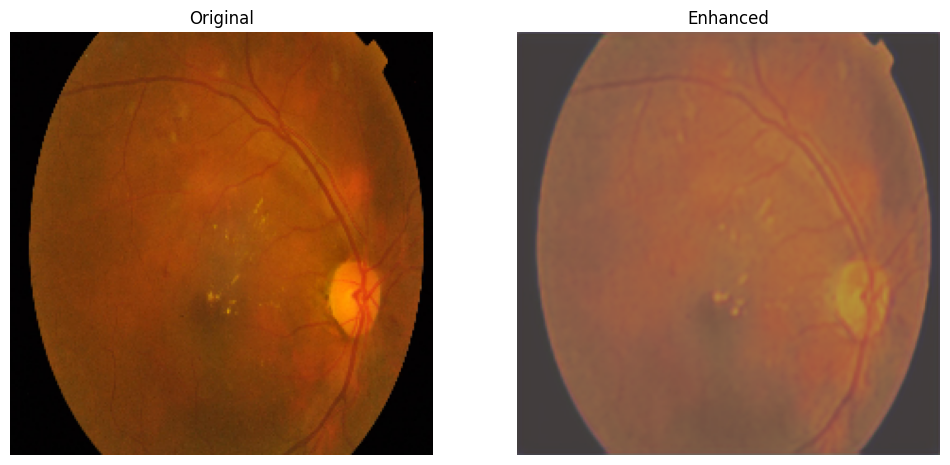

In [22]:
# Display results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(Image.open(test_image_path))
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(enhanced_image)
ax2.set_title('Enhanced')
ax2.axis('off')

plt.show()